# Breast Cancer Detection - Part 1: Data Loading and Preprocessing

This notebook covers the data loading and preprocessing steps for the breast cancer detection model.

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from skimage.filters import gaussian
from skimage.util import random_noise

## Define Paths

First, let's define the paths for our dataset and where we'll save our processed data.

In [10]:
# Define base paths
base_dir = os.path.dirname(os.getcwd())
dataset_path = os.path.join(base_dir, 'datasets', 'breast')
trained_models_path = os.path.join(base_dir, 'trained_models', 'breast_cancer_best_model')

# Create directories for processed data
train_dir = os.path.join(dataset_path, 'train_dir')
test_dir = os.path.join(dataset_path, 'test_dir')
all_images_dir = os.path.join(dataset_path, 'all_images')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(all_images_dir, exist_ok=True)
os.makedirs(os.path.join(train_dir, 'zeros'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'ones'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'zeros'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'ones'), exist_ok=True)

print(f"Dataset path: {dataset_path}")
print(f"Trained models path: {trained_models_path}")

Dataset path: c:\Users\Sayan\Desktop\MedX\backend\datasets\breast
Trained models path: c:\Users\Sayan\Desktop\MedX\backend\trained_models\breast_cancer_best_model


## Collect Images from Patient Directories

The breast cancer dataset is organized with patient IDs as directories and subdirectories '0' and '1' for non-cancer and cancer images.

In [11]:
# Get all patient directories
patient_dirs = [d for d in os.listdir(dataset_path) 
               if os.path.isdir(os.path.join(dataset_path, d)) and d.isdigit()]

print(f"Found {len(patient_dirs)} patient directories")
print(f"Example patient IDs: {patient_dirs[:5]}")

Found 40 patient directories
Example patient IDs: ['10253', '10254', '10255', '10256', '10257']


In [12]:
# Copy all images to the all_images_dir
image_count = 0
for patient in patient_dirs:
    # Process non-cancer images (0)
    path_0 = os.path.join(dataset_path, patient, '0')
    if os.path.exists(path_0):
        file_list_0 = os.listdir(path_0)
        for fname in file_list_0:
            src = os.path.join(path_0, fname)
            dst = os.path.join(all_images_dir, fname)
            if not os.path.exists(dst):  # Avoid duplicate copies
                shutil.copyfile(src, dst)
                image_count += 1
    
    # Process cancer images (1)
    path_1 = os.path.join(dataset_path, patient, '1')
    if os.path.exists(path_1):
        file_list_1 = os.listdir(path_1)
        for fname in file_list_1:
            src = os.path.join(path_1, fname)
            dst = os.path.join(all_images_dir, fname)
            if not os.path.exists(dst):  # Avoid duplicate copies
                shutil.copyfile(src, dst)
                image_count += 1
                
print(f"Collected {image_count} images in total")

Collected 0 images in total


## Create DataFrame and Extract Labels

Now we'll create a DataFrame with all the images and extract the target labels from the filenames.

In [13]:
# Create a DataFrame with all images
all_images = os.listdir(all_images_dir)
data = pd.DataFrame(all_images, columns=['image_id'])

# Extract target from filename
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)
data.head()

,image_id,target
0,10253_idx5_x1001_y1001_class0.png,0
1,10253_idx5_x1001_y1051_class0.png,0
2,10253_idx5_x1001_y1101_class0.png,0
3,10253_idx5_x1001_y1151_class0.png,0
4,10253_idx5_x1001_y1201_class0.png,0


In [14]:
# Extract patient ID from filename
def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    patient_id = a[0]
    return patient_id

data['patient_id'] = data['image_id'].apply(extract_patient_id)
data.head()

,image_id,target,patient_id
0,10253_idx5_x1001_y1001_class0.png,0,10253
1,10253_idx5_x1001_y1051_class0.png,0,10253
2,10253_idx5_x1001_y1101_class0.png,0,10253
3,10253_idx5_x1001_y1151_class0.png,0,10253
4,10253_idx5_x1001_y1201_class0.png,0,10253


## Explore Data Distribution

Class distribution:
target
0    38809
1    12975
Name: count, dtype: int64


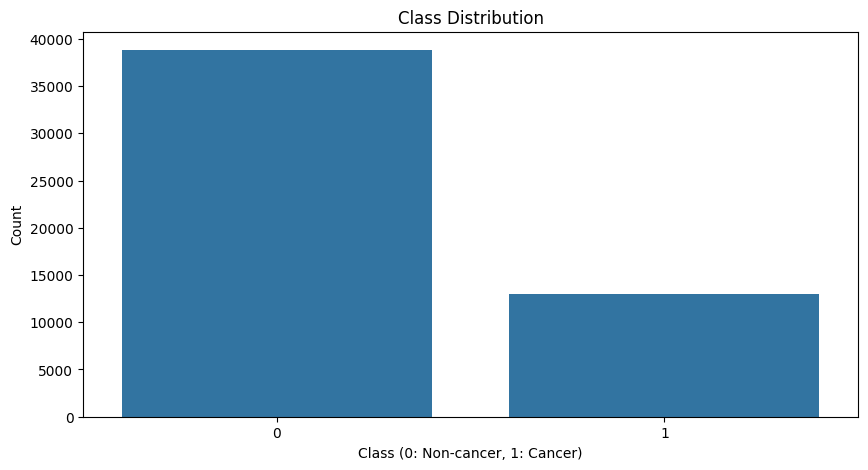

In [15]:
%matplotlib inline
# Check class distribution
print("Class distribution:")
print(data['target'].value_counts())

# Convert target to integer
data.target = data.target.astype(int)

# Plot distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='target', data=data)
plt.title('Class Distribution')
plt.xlabel('Class (0: Non-cancer, 1: Cancer)')
plt.ylabel('Count')
plt.show()

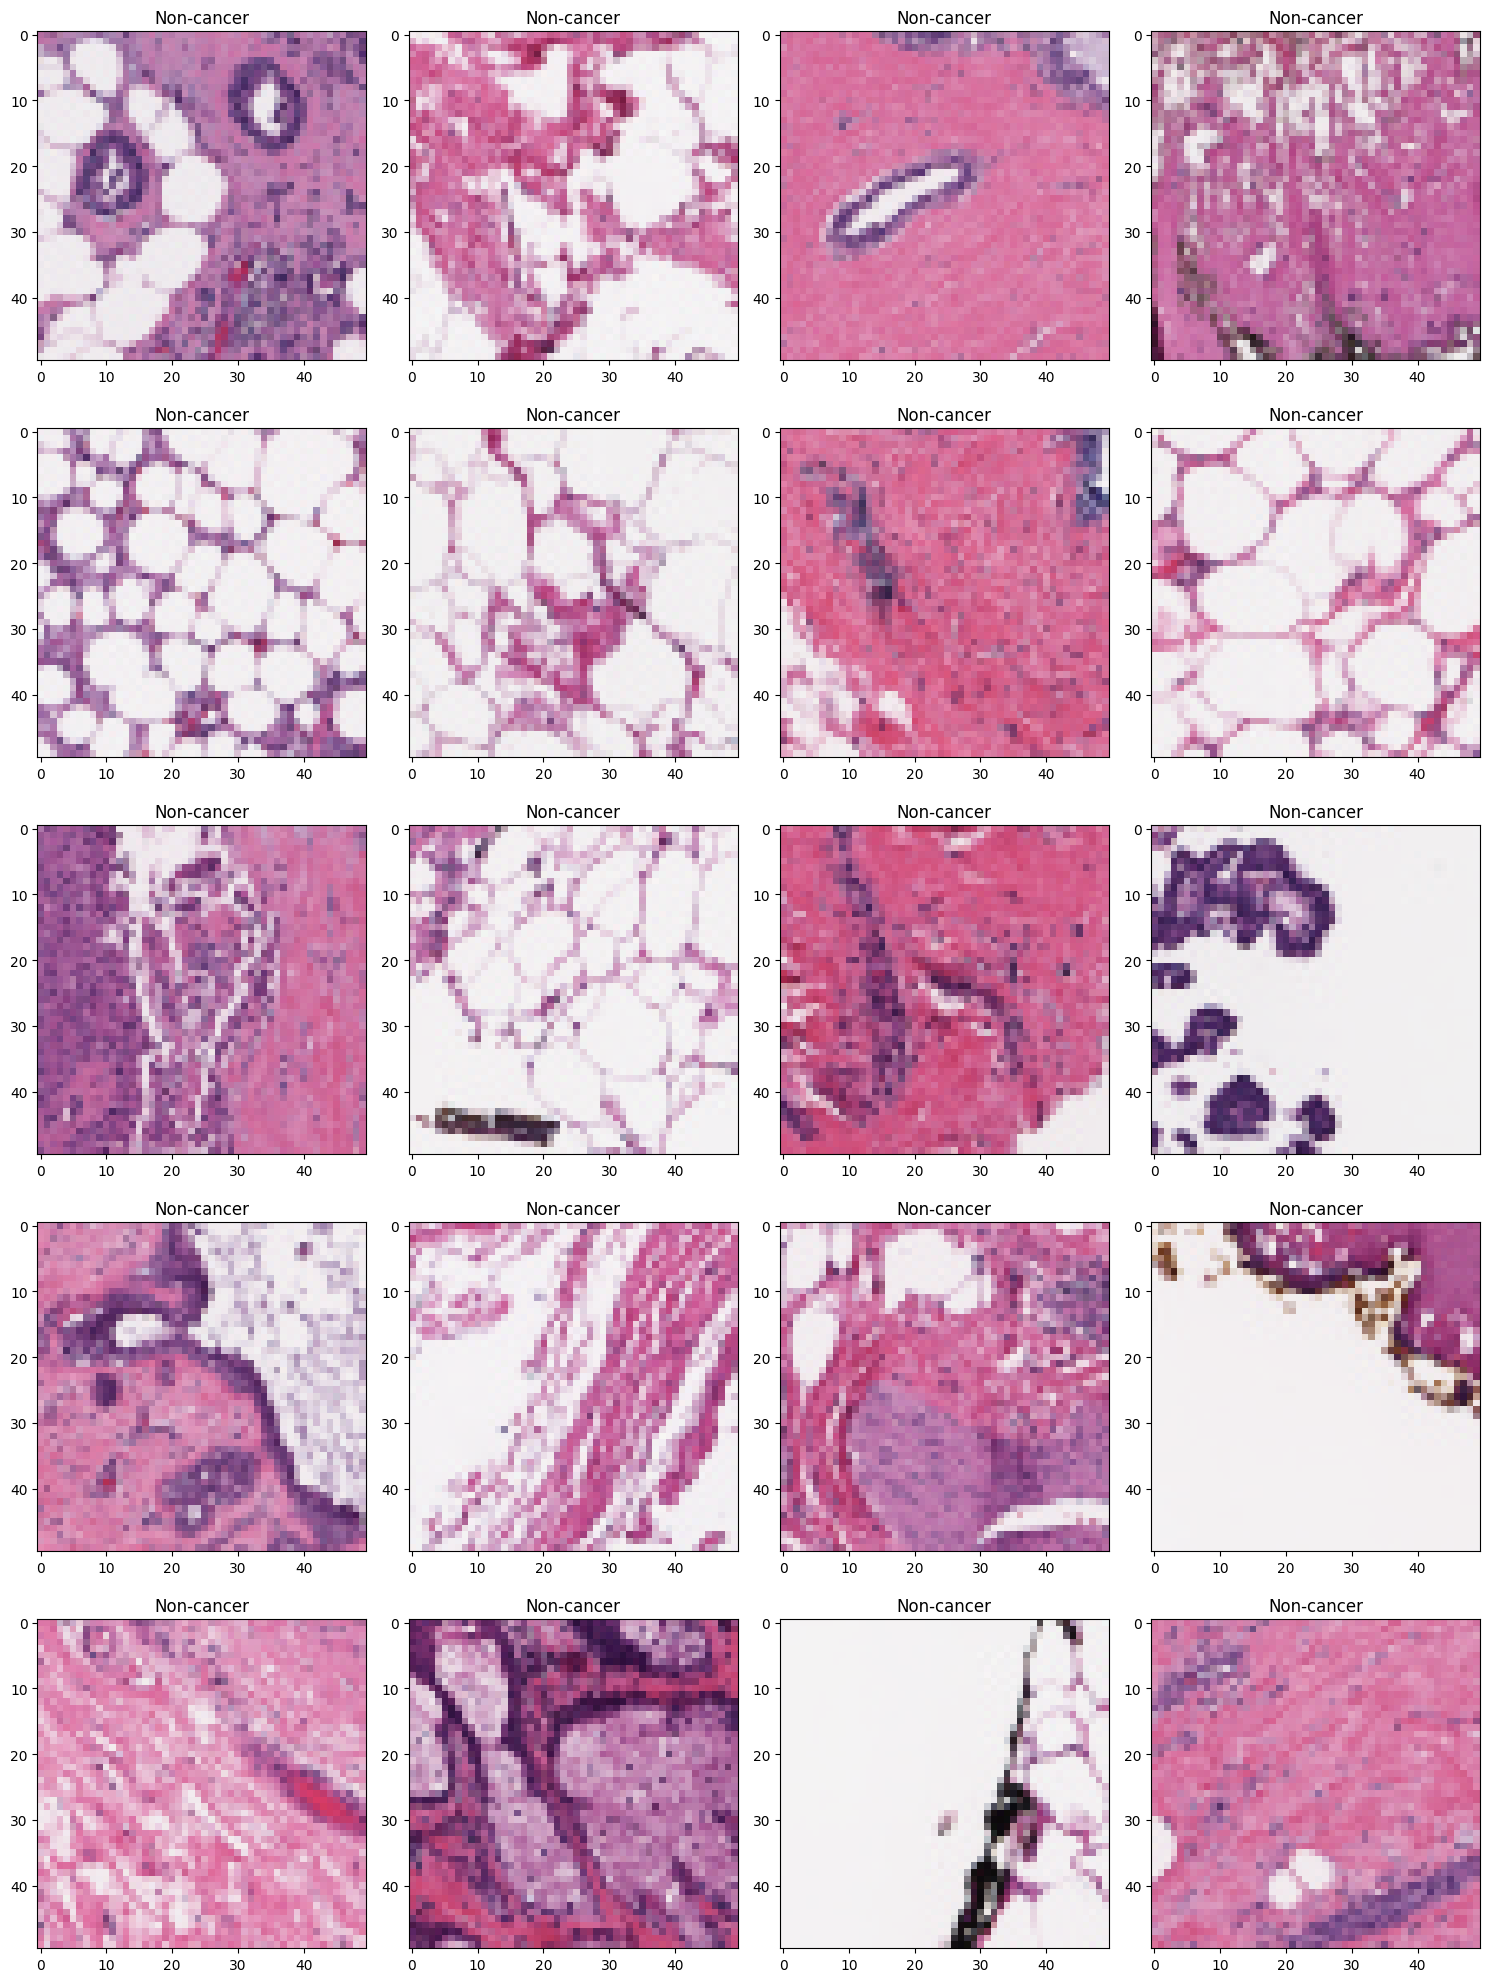

In [16]:
# Visualize some non-cancer images
fig, ax = plt.subplots(5, 4, figsize=(15, 20))
neg_selection = np.random.choice(data[data.target == 0].index, size=20, replace=False)

for n in range(5):
    for m in range(4):
        idx = neg_selection[m + 4*n]
        path = os.path.join(all_images_dir, data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n, m].imshow(image)
        ax[n, m].grid(False)
        ax[n, m].set_title('Non-cancer')

plt.tight_layout()
plt.show()

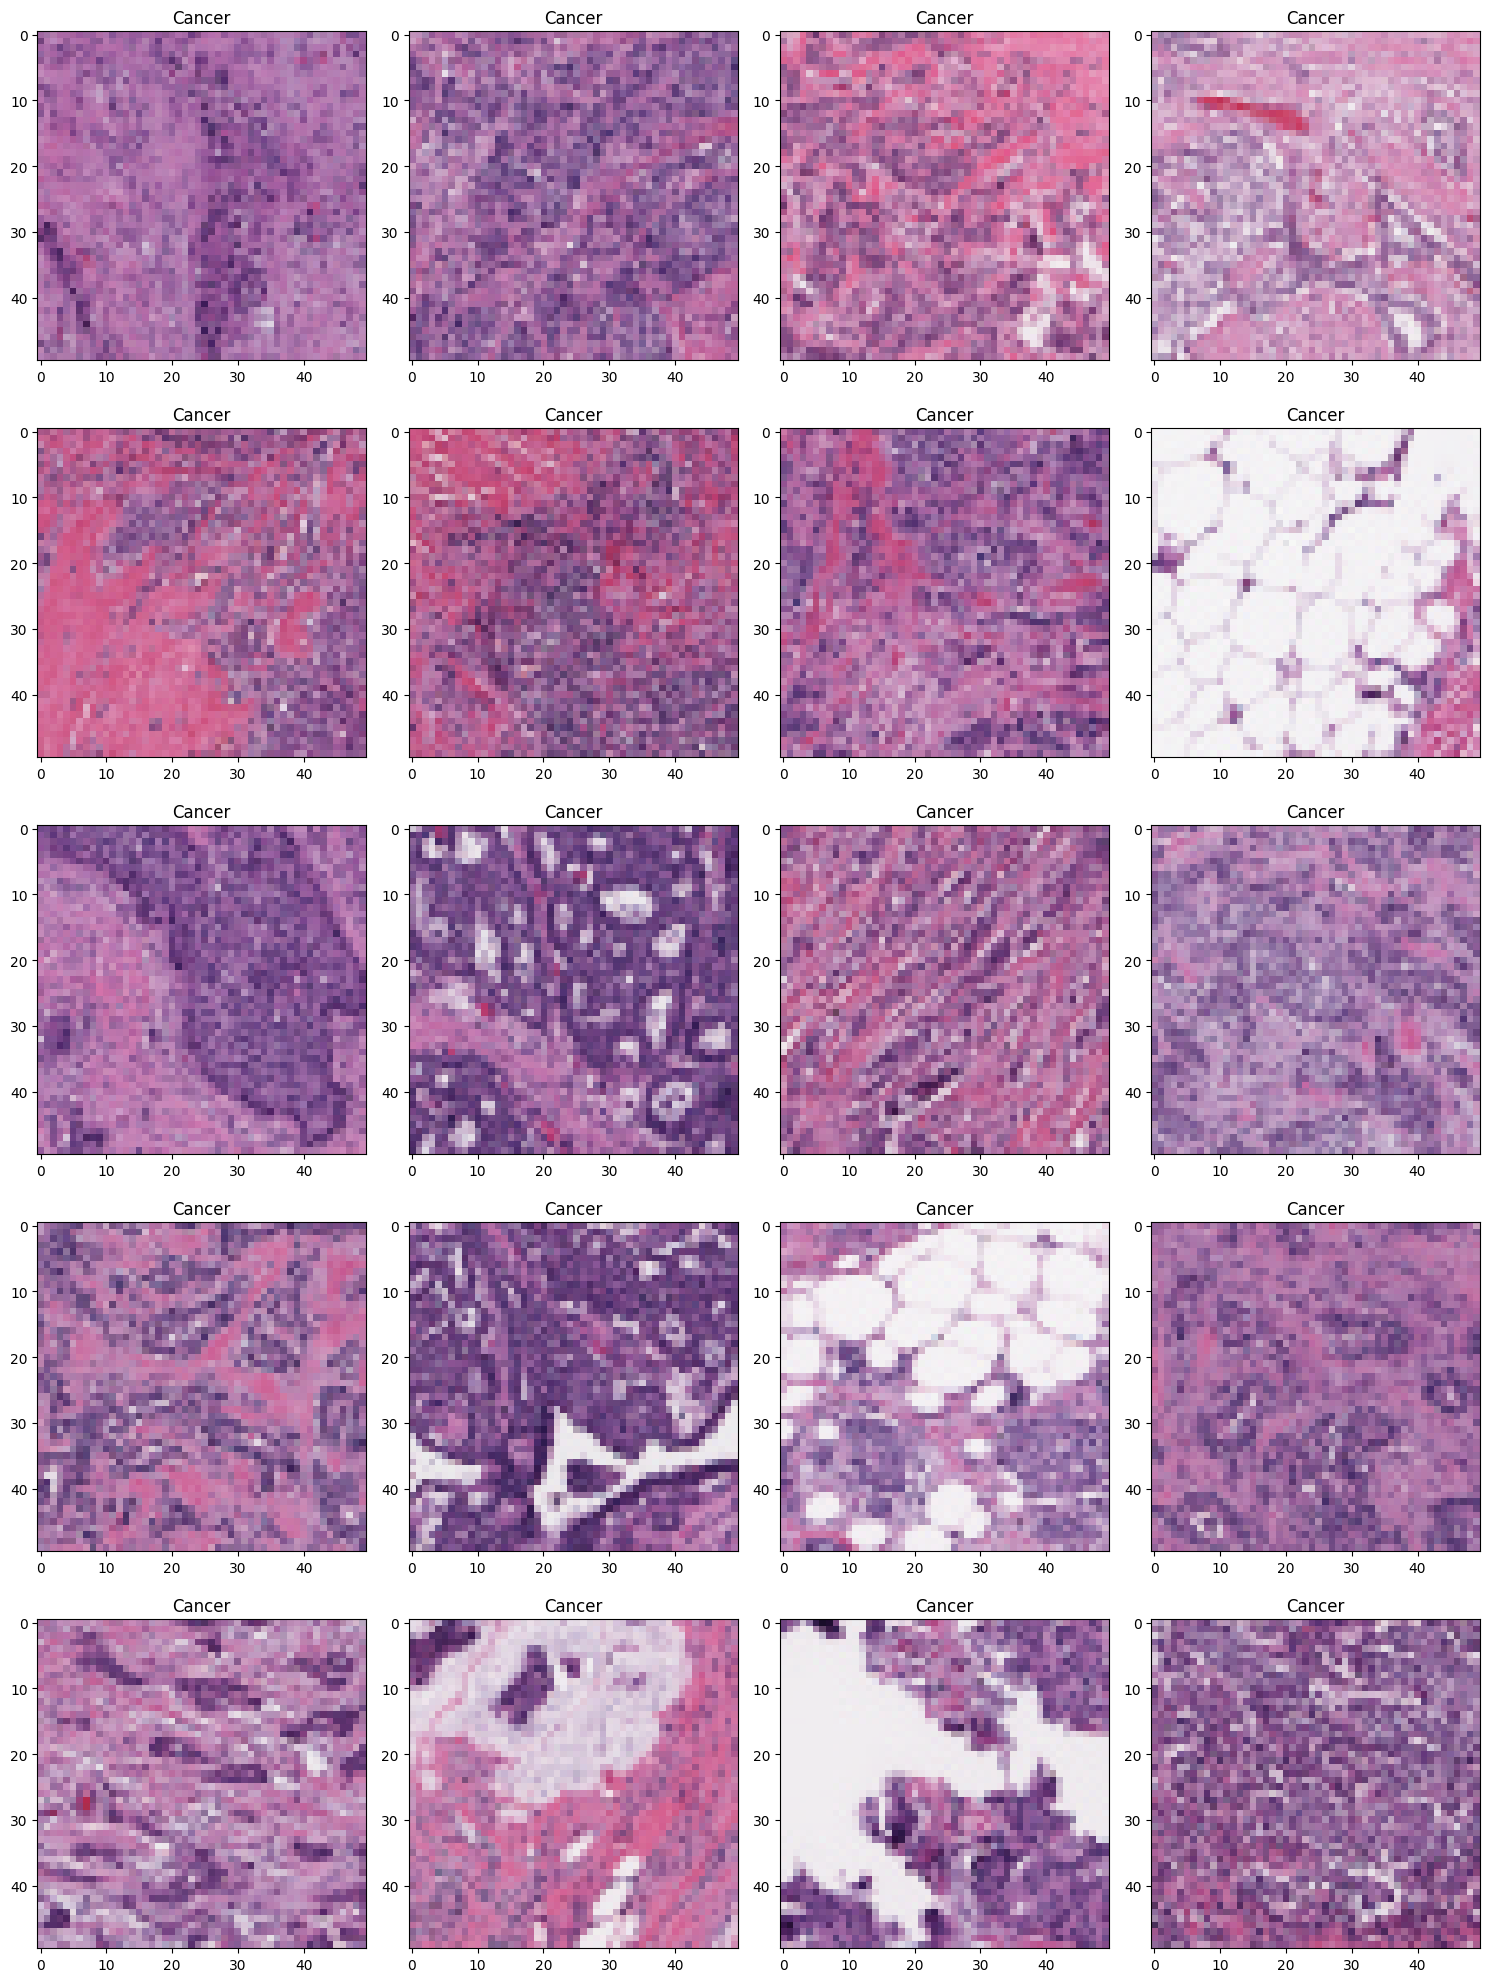

In [17]:
# Visualize some cancer images
fig, ax = plt.subplots(5, 4, figsize=(15, 20))
pos_selection = np.random.choice(data[data.target == 1].index, size=20, replace=False)

for n in range(5):
    for m in range(4):
        idx = pos_selection[m + 4*n]
        path = os.path.join(all_images_dir, data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n, m].imshow(image)
        ax[n, m].grid(False)
        ax[n, m].set_title('Cancer')

plt.tight_layout()
plt.show()

## Image Preprocessing and Augmentation

Let's apply some image preprocessing and augmentation techniques.

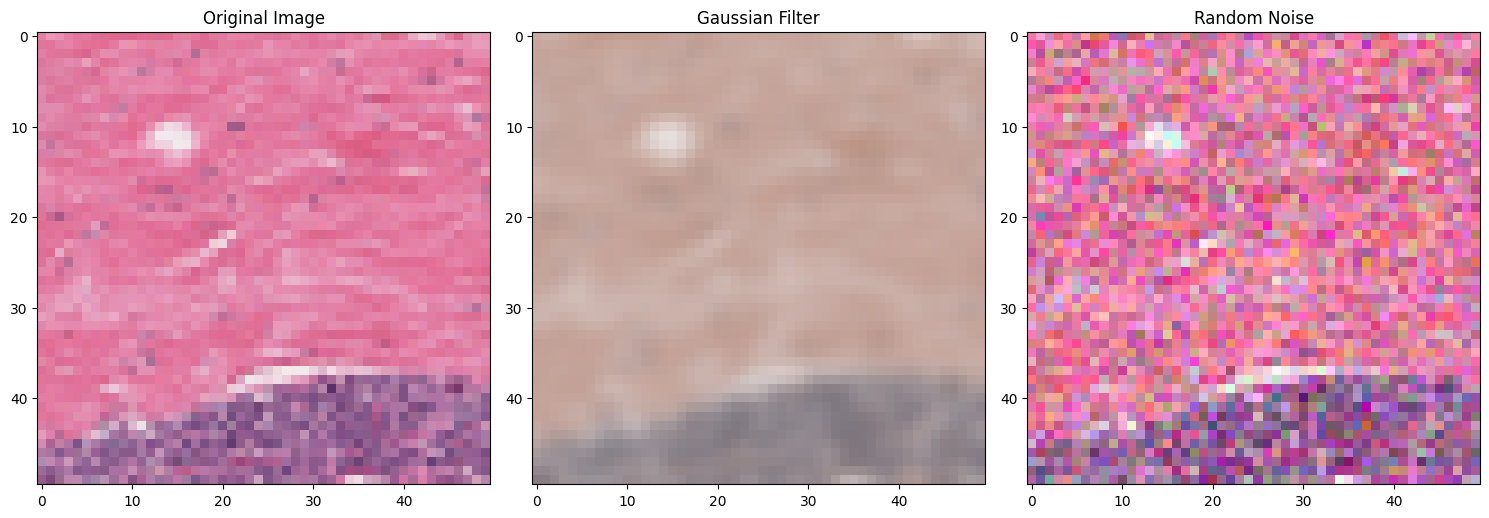

In [18]:
# Select a random image for demonstration
random_image_path = np.random.choice(data[data.target == 0].index, size=1, replace=False)
path = os.path.join(all_images_dir, data.loc[random_image_path[0], 'image_id'])
image = mpimg.imread(path)

# Display original image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')

# Apply Gaussian filter
gaussian_image = gaussian(image)
plt.subplot(1, 3, 2)
plt.imshow(gaussian_image)
plt.title('Gaussian Filter')

# Apply random noise
noise_image = random_noise(image)
plt.subplot(1, 3, 3)
plt.imshow(noise_image)
plt.title('Random Noise')

plt.tight_layout()
plt.show()

## Balance and Split the Dataset

Now we'll balance the dataset and split it into training and testing sets.

In [19]:
# Balance the dataset
target_sample_size = min(
    len(data[data.target == 0]),
    len(data[data.target == 1]),
    10000  # Maximum 10,000 samples per class
)

df_0 = data[data.target == 0].sample(target_sample_size, random_state=42)
df_1 = data[data.target == 1].sample(target_sample_size, random_state=42)
balanced_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

print(f"Balanced dataset with {target_sample_size} samples per class")
print(balanced_data.target.value_counts())

Balanced dataset with 10000 samples per class
target
0    10000
1    10000
Name: count, dtype: int64


In [20]:
# Split into training and testing sets
y = balanced_data['target']
data_train, data_test = train_test_split(balanced_data, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {len(data_train)}, Testing samples: {len(data_test)}")

Training samples: 16000, Testing samples: 4000


## Organize Images into Train and Test Directories

Finally, we'll copy the images into the appropriate train and test directories.

In [21]:
# Set image_id as index for easier lookup
balanced_data.set_index('image_id', inplace=True)

# Copy training files
print("Copying training files...")
for image in data_train['image_id']:
    target = balanced_data.loc[image, 'target']
    label = 'zeros' if target == 0 else 'ones'
    src = os.path.join(all_images_dir, image)
    dst = os.path.join(train_dir, label, image)
    shutil.copyfile(src, dst)
    
# Copy test files
print("Copying test files...")
for image in data_test['image_id']:
    target = balanced_data.loc[image, 'target']
    label = 'zeros' if target == 0 else 'ones'
    src = os.path.join(all_images_dir, image)
    dst = os.path.join(test_dir, label, image)
    shutil.copyfile(src, dst)
    
print(f"Data preparation complete. Training samples: {len(data_train)}, Testing samples: {len(data_test)}")

Copying training files...
Copying test files...
Data preparation complete. Training samples: 16000, Testing samples: 4000


In [22]:
# Verify the directory structure
print(f"Training zeros: {len(os.listdir(os.path.join(train_dir, 'zeros')))}")
print(f"Training ones: {len(os.listdir(os.path.join(train_dir, 'ones')))}")
print(f"Testing zeros: {len(os.listdir(os.path.join(test_dir, 'zeros')))}")
print(f"Testing ones: {len(os.listdir(os.path.join(test_dir, 'ones')))}")

Training zeros: 8000
Training ones: 8000
Testing zeros: 2000
Testing ones: 2000


# Breast Cancer Detection - Part 2: Model Architecture Definition

This notebook covers the model architecture definition for the breast cancer detection model.

In [23]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.utils import plot_model

## Define Paths

First, let's define the paths for our dataset and where we'll save our models.

In [24]:
# Define base paths
base_dir = os.path.dirname(os.getcwd())
dataset_path = os.path.join(base_dir, 'datasets', 'breast')
trained_models_path = os.path.join(base_dir, 'trained_models', 'breast_cancer_best_model')

# Create directory for saving models
os.makedirs(trained_models_path, exist_ok=True)

print(f"Dataset path: {dataset_path}")
print(f"Trained models path: {trained_models_path}")

Dataset path: c:\Users\Sayan\Desktop\MedX\backend\datasets\breast
Trained models path: c:\Users\Sayan\Desktop\MedX\backend\trained_models\breast_cancer_best_model


## Define Model Parameters

In [25]:
# Model parameters
img_height = 50
img_width = 50
batch_size = 32
epochs = 30

# Available model architectures
model_architectures = ['simple_cnn', 'resnet50', 'efficientnet', 'mobilenet']

## Simple CNN Architecture

Let's define a simple CNN architecture for breast cancer detection.

In [26]:
def create_simple_cnn():
    """
    Create a simple CNN model for breast cancer detection
    
    Returns:
        A compiled Keras model
    """
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(4,4), input_shape=(img_height, img_width, 3), activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create and summarize the model
simple_cnn_model = create_simple_cnn()
simple_cnn_model.summary()

c:\Users\Sayan\anaconda3\envs\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 47, 47, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,965,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,983,682 (15.20 MB)

 Trainable params: 3,983,682 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Visualize the model architecture
try:
    plot_model(simple_cnn_model, to_file=os.path.join(trained_models_path, 'simple_cnn_architecture.png'), 
               show_shapes=True, show_layer_names=True)
    from IPython.display import Image
    Image(os.path.join(trained_models_path, 'simple_cnn_architecture.png'))
except Exception as e:
    print(f"Could not plot model: {e}")

You must install pydot (`pip install pydot`) for `plot_model` to work.


## ResNet50 Architecture

Now let's define a model based on the pre-trained ResNet50 architecture.

In [28]:
def create_resnet50():
    """
    Create a ResNet50-based model for breast cancer detection
    
    Returns:
        A compiled Keras model
    """
    base_model = ResNet50(weights='imagenet', include_top=False, 
                         input_shape=(img_height, img_width, 3))
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
        
    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create and summarize the model
resnet_model = create_resnet50()
resnet_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50, 50, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 56, 56, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 25, 25,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 25, 25,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 25, 25,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 27, 27,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 13, 13,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 13, 13,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 13, 13,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 13, 13,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 13, 13,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 13, 13,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 13, 13,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 13, 13,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 13, 13,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 13, 13,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 13, 13,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## EfficientNet Architecture

Let's define a model based on the pre-trained EfficientNetB0 architecture.

In [29]:
def create_efficientnet():
    """
    Create an EfficientNet-based model for breast cancer detection
    
    Returns:
        A compiled Keras model
    """
    base_model = EfficientNetB0(weights='imagenet', include_top=False, 
                              input_shape=(img_height, img_width, 3))
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
        
    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create and summarize the model
efficientnet_model = create_efficientnet()
efficientnet_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 50, 50, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 50, 50, 3) │          0 │ input_layer_2[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 50, 50, 3) │          7 │ rescaling[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 50, 50, 3) │          0 │ normalization[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 51, 51, 3) │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 25, 25,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 25, 25,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 25, 25,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 25, 25,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 25, 25,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 25, 25,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 25, 25,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 25, 25,    │        512 │ block1a_se_excit

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## MobileNet Architecture

Finally, let's define a model based on the pre-trained MobileNetV2 architecture.

In [30]:
def create_mobilenet():
    """
    Create a MobileNetV2-based model for breast cancer detection
    
    Returns:
        A compiled Keras model
    """
    base_model = MobileNetV2(weights='imagenet', include_top=False, 
                           input_shape=(img_height, img_width, 3))
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
        
    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create and summarize the model
mobilenet_model = create_mobilenet()
mobilenet_model.summary()

C:\Users\Sayan\AppData\Local\Temp\ipykernel_800\2897438434.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False,


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 50, 50, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 25, 25,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 25, 25,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 25, 25,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 25, 25,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 25, 25,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 25, 25,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 25, 25,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 25, 25,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 25, 25,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 25, 25,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 25, 25,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 27, 27,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 13, 13,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 13, 13,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 13, 13,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 13, 13,    │      2,304 │ block_1_depthwis

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Model Builder Function

Let's create a function to build a model based on the specified architecture.

In [31]:
def build_model(architecture='simple_cnn'):
    """
    Build a model based on the specified architecture
    
    Args:
        architecture: The model architecture to use
        
    Returns:
        A compiled Keras model
    """
    if architecture == 'simple_cnn':
        return create_simple_cnn()
    elif architecture == 'resnet50':
        return create_resnet50()
    elif architecture == 'efficientnet':
        return create_efficientnet()
    elif architecture == 'mobilenet':
        return create_mobilenet()
    else:
        raise ValueError(f"Unknown model architecture: {architecture}. Available architectures: {model_architectures}")

# Test the builder function
test_model = build_model('simple_cnn')
print(f"Successfully built model with architecture: simple_cnn")

Successfully built model with architecture: simple_cnn


## Save Model Architecture

Let's save the model architecture to JSON for later use.

In [32]:
# Save simple CNN model architecture to JSON
model_json = simple_cnn_model.to_json()
with open(os.path.join(trained_models_path, 'simple_cnn_model.json'), 'w') as json_file:
    json_file.write(model_json)
    
print(f"Model architecture saved to {os.path.join(trained_models_path, 'simple_cnn_model.json')}")

Model architecture saved to c:\Users\Sayan\Desktop\MedX\backend\trained_models\breast_cancer_best_model\simple_cnn_model.json


# Breast Cancer Detection - Part 3: Training Pipeline

This notebook covers the training pipeline for the breast cancer detection model.

In [35]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import model_from_json

# Reference model architectures from previous cells
# No need to import since everything is in the same notebook now
# Just make sure these variables are defined in earlier cells

## Define Paths

First, let's define the paths for our dataset and where we'll save our models.

In [36]:
# Define base paths
base_dir = os.path.dirname(os.getcwd())
dataset_path = os.path.join(base_dir, 'datasets', 'breast')
trained_models_path = os.path.join(base_dir, 'trained_models', 'breast_cancer_best_model')

# Define train and test directories
train_dir = os.path.join(dataset_path, 'train_dir')
test_dir = os.path.join(dataset_path, 'test_dir')

print(f"Dataset path: {dataset_path}")
print(f"Trained models path: {trained_models_path}")
print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

Dataset path: c:\Users\Sayan\Desktop\MedX\backend\datasets\breast
Trained models path: c:\Users\Sayan\Desktop\MedX\backend\trained_models\breast_cancer_best_model
Train directory: c:\Users\Sayan\Desktop\MedX\backend\datasets\breast\train_dir
Test directory: c:\Users\Sayan\Desktop\MedX\backend\datasets\breast\test_dir


## Set Up Data Generators

Let's set up data generators for training and validation with data augmentation.

In [37]:
# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


## Set Up Callbacks

Let's set up callbacks for early stopping and model checkpointing.

In [38]:
# Set up callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    os.path.join(trained_models_path, 'model.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

## Train the Model

Now let's train the model with the specified architecture.

In [39]:
# Select architecture
selected_architecture = 'simple_cnn'

# Build the model
model = build_model(selected_architecture)
model.summary()

c:\Users\Sayan\anaconda3\envs\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 47, 47, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 44, 44, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     3,965,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,983,682 (15.20 MB)

 Trainable params: 3,983,682 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8044 - loss: 0.4384
Epoch 1: val_accuracy did not improve from 0.82675
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.8044 - loss: 0.4384 - val_accuracy: 0.8185 - val_loss: 0.4267
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8143 - loss: 0.4253
Epoch 2: val_accuracy did not improve from 0.82675
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - accuracy: 0.8143 - loss: 0.4253 - val_accuracy: 0.8213 - val_loss: 0.4112
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8112 - loss: 0.4318
Epoch 3: val_accuracy did not improve from 0.82675
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - accuracy: 0.8112 - loss: 0.4318 - val_accuracy: 0.8238 - val_loss: 0.4060
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8115 - loss: 0.4218
Epoch 4: val_accuracy improved from 0.82675 to 0.82825, saving model to c:\Users\Sayan\Desktop\MedX\backend\trained_models\breast_cancer_best_

500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.8115 - loss: 0.4218 - val_accuracy: 0.8282 - val_loss: 0.3971
Epoch 5/30
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8143 - loss: 0.4218
Epoch 5: val_accuracy did not improve from 0.82825
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.8143 - loss: 0.4219 - val_accuracy: 0.8108 - val_loss: 0.4140
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8196 - loss: 0.4172
Epoch 6: val_accuracy did not improve from 0.82825
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.8196 - loss: 0.4172 - val_accuracy: 0.8255 - val_loss: 0.4074
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8129 - loss: 0.4252
Epoch 7: val_accuracy did not improve from 0.82825
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.8129 - loss: 0.4252 - val_accuracy: 0.8255 - val_loss: 0.4018
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8128 - loss: 0.4161
Epoch 8: val_accuracy d

500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.8247 - loss: 0.4063 - val_accuracy: 0.8322 - val_loss: 0.3902
Epoch 11/30
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8268 - loss: 0.4019
Epoch 11: val_accuracy did not improve from 0.83225
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.8267 - loss: 0.4019 - val_accuracy: 0.8315 - val_loss: 0.4296
Epoch 12/30
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8169 - loss: 0.4232
Epoch 12: val_accuracy did not improve from 0.83225
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.8169 - loss: 0.4231 - val_accuracy: 0.8192 - val_loss: 0.4073
Epoch 13/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8222 - loss: 0.4107
Epoch 13: val_accuracy did not improve from 0.83225
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.8223 - loss: 0.4107 - val_accuracy: 0.8310 - val_loss: 0.4043
Epoch 14/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8274 - loss: 0.3972
Epoch 14: val_ac

500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.8339 - loss: 0.3961 - val_accuracy: 0.8345 - val_loss: 0.3794
Epoch 20/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8300 - loss: 0.4003
Epoch 20: val_accuracy did not improve from 0.83450
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.8299 - loss: 0.4003 - val_accuracy: 0.8300 - val_loss: 0.3851
Epoch 21/30
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8253 - loss: 0.4097
Epoch 21: val_accuracy did not improve from 0.83450
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 65ms/step - accuracy: 0.8253 - loss: 0.4097 - val_accuracy: 0.8250 - val_loss: 0.3941
Epoch 22/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8314 - loss: 0.3964
Epoch 22: val_accuracy did not improve from 0.83450
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.8314 - loss: 0.3964 - val_accuracy: 0.8307 - val_loss: 0.3858
Epoch 23/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8307 - loss: 0.3983
Epoch 23: val_ac

## Save Model Architecture and Weights

Let's save the model architecture and weights for later use.

In [42]:
# Save model architecture
model_json = model.to_json()
with open(os.path.join(trained_models_path, 'model.json'), 'w') as json_file:
    json_file.write(model_json)
    
print(f"Model architecture saved to {os.path.join(trained_models_path, 'model.json')}")

Model architecture saved to c:\Users\Sayan\Desktop\MedX\backend\trained_models\breast_cancer_best_model\model.json


## Save Model Metrics

Let's save the model metrics for later reference.

In [43]:
# Evaluate the model
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation accuracy: {val_acc:.4f}, Validation loss: {val_loss:.4f}")

# Save model metrics
metrics = {
    'model_name': selected_architecture,
    'accuracy': float(val_acc),
    'loss': float(val_loss)
}

with open(os.path.join(trained_models_path, 'metrics.json'), 'w') as f:
    json.dump(metrics, f)
    
print(f"Model metrics saved to {os.path.join(trained_models_path, 'metrics.json')}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8284 - loss: 0.3911
Validation accuracy: 0.8345, Validation loss: 0.3794
Model metrics saved to c:\Users\Sayan\Desktop\MedX\backend\trained_models\breast_cancer_best_model\metrics.json


## Plot Training History

Let's plot the training history to visualize the model's performance.

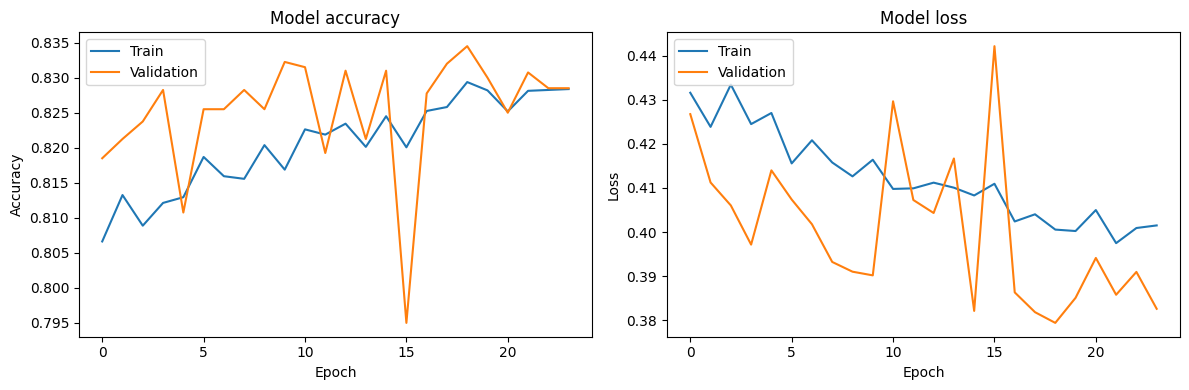

In [44]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(trained_models_path, 'training_history.png'))
plt.show()

## Load the Best Model

Let's load the best model saved during training.

In [45]:
# Load model architecture
with open(os.path.join(trained_models_path, 'model.json'), 'r') as json_file:
    loaded_model_json = json_file.read()
    
loaded_model = model_from_json(loaded_model_json)

# Load model weights
loaded_model.load_weights(os.path.join(trained_models_path, 'model.h5'))

# Compile model
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Model loaded successfully")

Model loaded successfully


In [46]:
# Evaluate the loaded model
loaded_val_loss, loaded_val_acc = loaded_model.evaluate(validation_generator)
print(f"Loaded model validation accuracy: {loaded_val_acc:.4f}, validation loss: {loaded_val_loss:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8237 - loss: 0.3904
Loaded model validation accuracy: 0.8345, validation loss: 0.3794


# Breast Cancer Detection - Part 4: Evaluation and Visualization

This notebook covers the evaluation and visualization of the breast cancer detection model.

In [47]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.image as mpimg

## Define Paths

First, let's define the paths for our dataset and where our models are saved.

In [48]:
# Define base paths
base_dir = os.path.dirname(os.getcwd())
dataset_path = os.path.join(base_dir, 'datasets', 'breast')
trained_models_path = os.path.join(base_dir, 'trained_models', 'breast_cancer_best_model')

# Define train and test directories
train_dir = os.path.join(dataset_path, 'train_dir')
test_dir = os.path.join(dataset_path, 'test_dir')

print(f"Dataset path: {dataset_path}")
print(f"Trained models path: {trained_models_path}")
print(f"Test directory: {test_dir}")

Dataset path: c:\Users\Sayan\Desktop\MedX\backend\datasets\breast
Trained models path: c:\Users\Sayan\Desktop\MedX\backend\trained_models\breast_cancer_best_model
Test directory: c:\Users\Sayan\Desktop\MedX\backend\datasets\breast\test_dir


## Load the Trained Model

Let's load the trained model from the saved files.

In [49]:
# Define model parameters
img_height = 50
img_width = 50
batch_size = 32

# Load model architecture
with open(os.path.join(trained_models_path, 'model.json'), 'r') as json_file:
    loaded_model_json = json_file.read()
    
model = model_from_json(loaded_model_json)

# Load model weights
model.load_weights(os.path.join(trained_models_path, 'model.h5'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Load model metrics
with open(os.path.join(trained_models_path, 'metrics.json'), 'r') as f:
    metrics = json.load(f)
    
print(f"Loaded {metrics.get('model_name', 'unknown')} model with accuracy: {metrics.get('accuracy', 'N/A')}")

Loaded simple_cnn model with accuracy: 0.8345000147819519


## Create Test Data Generator

Let's create a data generator for the test data.

In [50]:
# Create test data generator
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for confusion matrix
)

Found 4000 images belonging to 2 classes.


## Evaluate the Model

Let's evaluate the model on the test data.

In [51]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8468 - loss: 0.3878
Test accuracy: 0.8345, Test loss: 0.3794


## Generate Predictions

Let's generate predictions on the test data for further analysis.

In [53]:
# Reset the generator
test_generator.reset()

# Get predictions
steps = int(np.ceil(test_generator.samples / batch_size))
predictions = model.predict(test_generator, steps=steps)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes[:len(predicted_classes)]

# Get class labels
class_labels = list(test_generator.class_indices.keys())
print(f"Class labels: {class_labels}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Class labels: ['ones', 'zeros']


## Confusion Matrix

Let's create a confusion matrix to visualize the model's performance.

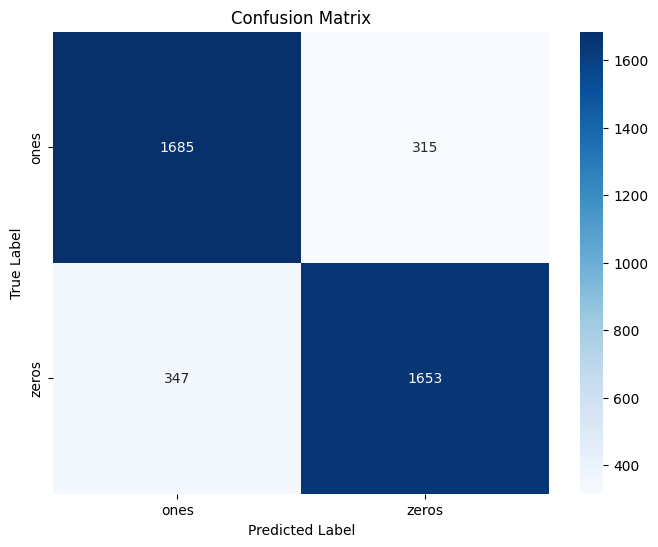

In [54]:
# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(trained_models_path, 'confusion_matrix.png'))
plt.show()

## Classification Report

Let's generate a classification report with precision, recall, and F1-score.

In [55]:
# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

# Save classification report
with open(os.path.join(trained_models_path, 'classification_report.txt'), 'w') as f:
    f.write(report)

Classification Report:
              precision    recall  f1-score   support

        ones       0.83      0.84      0.84      2000
       zeros       0.84      0.83      0.83      2000

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



## ROC Curve

Let's create a ROC curve to visualize the model's performance.

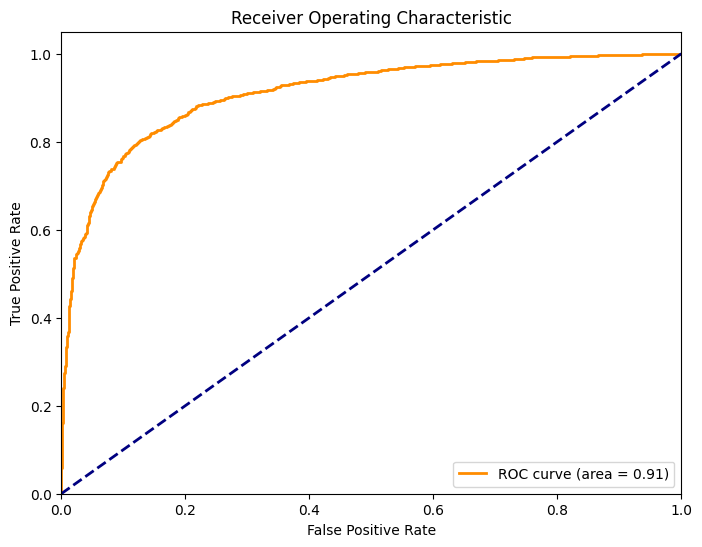

In [56]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_classes, predictions[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(os.path.join(trained_models_path, 'roc_curve.png'))
plt.show()

## Visualize Model Predictions

Let's visualize some of the model's predictions on test images.

In [57]:
# Function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = tf.expand_dims(img_array, 0)  # Create batch dimension
    return img, img_array

# Function to make prediction on a single image
def predict_image(image_path):
    img, img_array = load_and_preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    return img, predicted_class, confidence, predictions[0]

In [58]:
# Get some test images
zeros_dir = os.path.join(test_dir, 'zeros')
ones_dir = os.path.join(test_dir, 'ones')

zeros_images = [os.path.join(zeros_dir, f) for f in os.listdir(zeros_dir)[:5]]
ones_images = [os.path.join(ones_dir, f) for f in os.listdir(ones_dir)[:5]]

test_images = zeros_images + ones_images
true_labels = [0] * len(zeros_images) + [1] * len(ones_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


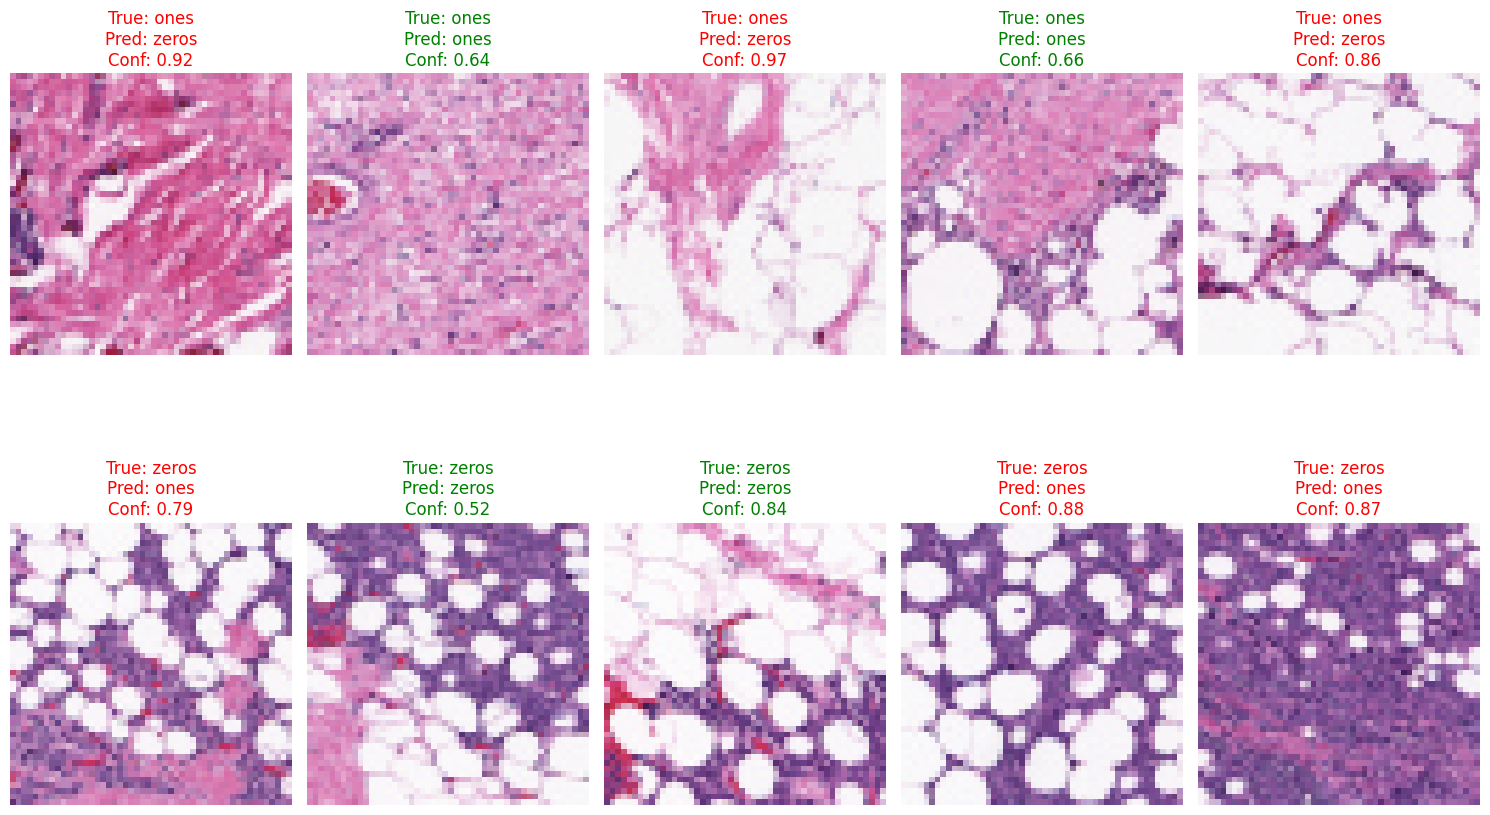

In [59]:
# Visualize predictions
plt.figure(figsize=(15, 10))

for i, (image_path, true_label) in enumerate(zip(test_images, true_labels)):
    img, predicted_class, confidence, probs = predict_image(image_path)
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    
    color = 'green' if predicted_class == true_label else 'red'
    title = f"True: {class_labels[true_label]}\nPred: {class_labels[predicted_class]}\nConf: {confidence:.2f}"
    plt.title(title, color=color)
    plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(trained_models_path, 'prediction_examples.png'))
plt.show()

## Save Updated Metrics

Let's save the updated metrics with test accuracy.

In [60]:
# Update metrics with test accuracy
metrics['test_accuracy'] = float(test_acc)
metrics['test_loss'] = float(test_loss)
metrics['roc_auc'] = float(roc_auc)

# Save updated metrics
with open(os.path.join(trained_models_path, 'metrics.json'), 'w') as f:
    json.dump(metrics, f, indent=4)
    
print(f"Updated metrics saved to {os.path.join(trained_models_path, 'metrics.json')}")

Updated metrics saved to c:\Users\Sayan\Desktop\MedX\backend\trained_models\breast_cancer_best_model\metrics.json


# Breast Cancer Detection - Part 5: Prediction

This notebook covers the prediction functionality for the breast cancer detection model.

In [61]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json
import matplotlib.image as mpimg

## Define Paths

First, let's define the paths for our dataset and where our models are saved.

In [62]:
# Define base paths
base_dir = os.path.dirname(os.getcwd())
dataset_path = os.path.join(base_dir, 'datasets', 'breast')
trained_models_path = os.path.join(base_dir, 'trained_models', 'breast_cancer_best_model')

# Define test directory
test_dir = os.path.join(dataset_path, 'test_dir')

print(f"Dataset path: {dataset_path}")
print(f"Trained models path: {trained_models_path}")

Dataset path: c:\Users\Sayan\Desktop\MedX\backend\datasets\breast
Trained models path: c:\Users\Sayan\Desktop\MedX\backend\trained_models\breast_cancer_best_model


## Load the Trained Model

Let's load the trained model from the saved files.

In [63]:
# Define model parameters
img_height = 50
img_width = 50

# Load model architecture
with open(os.path.join(trained_models_path, 'model.json'), 'r') as json_file:
    loaded_model_json = json_file.read()
    
model = model_from_json(loaded_model_json)

# Load model weights
model.load_weights(os.path.join(trained_models_path, 'model.h5'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Load model metrics
with open(os.path.join(trained_models_path, 'metrics.json'), 'r') as f:
    metrics = json.load(f)
    
print(f"Loaded {metrics.get('model_name', 'unknown')} model with accuracy: {metrics.get('accuracy', 'N/A')}")

Loaded simple_cnn model with accuracy: 0.8345000147819519


## Create Prediction Function

Let's create a function to make predictions on a single image.

In [64]:
# Function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = tf.expand_dims(img_array, 0)  # Create batch dimension
    return img, img_array

# Function to make prediction on a single image
def predict_image(image_path):
    img, img_array = load_and_preprocess_image(image_path)
    predictions = model.predict(img_array)
    cancer_probability = float(predictions[0][1])
    non_cancer_probability = float(predictions[0][0])
    has_cancer = bool(cancer_probability > 0.5)
    
    return {
        "cancer_probability": cancer_probability,
        "non_cancer_probability": non_cancer_probability,
        "has_cancer": has_cancer
    }

## Test the Prediction Function

Let's test the prediction function on some test images.

In [65]:
# Get some test images
zeros_dir = os.path.join(test_dir, 'zeros')
ones_dir = os.path.join(test_dir, 'ones')

zeros_images = [os.path.join(zeros_dir, f) for f in os.listdir(zeros_dir)[:3]]
ones_images = [os.path.join(ones_dir, f) for f in os.listdir(ones_dir)[:3]]

test_images = zeros_images + ones_images
true_labels = ['Non-Cancer'] * len(zeros_images) + ['Cancer'] * len(ones_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


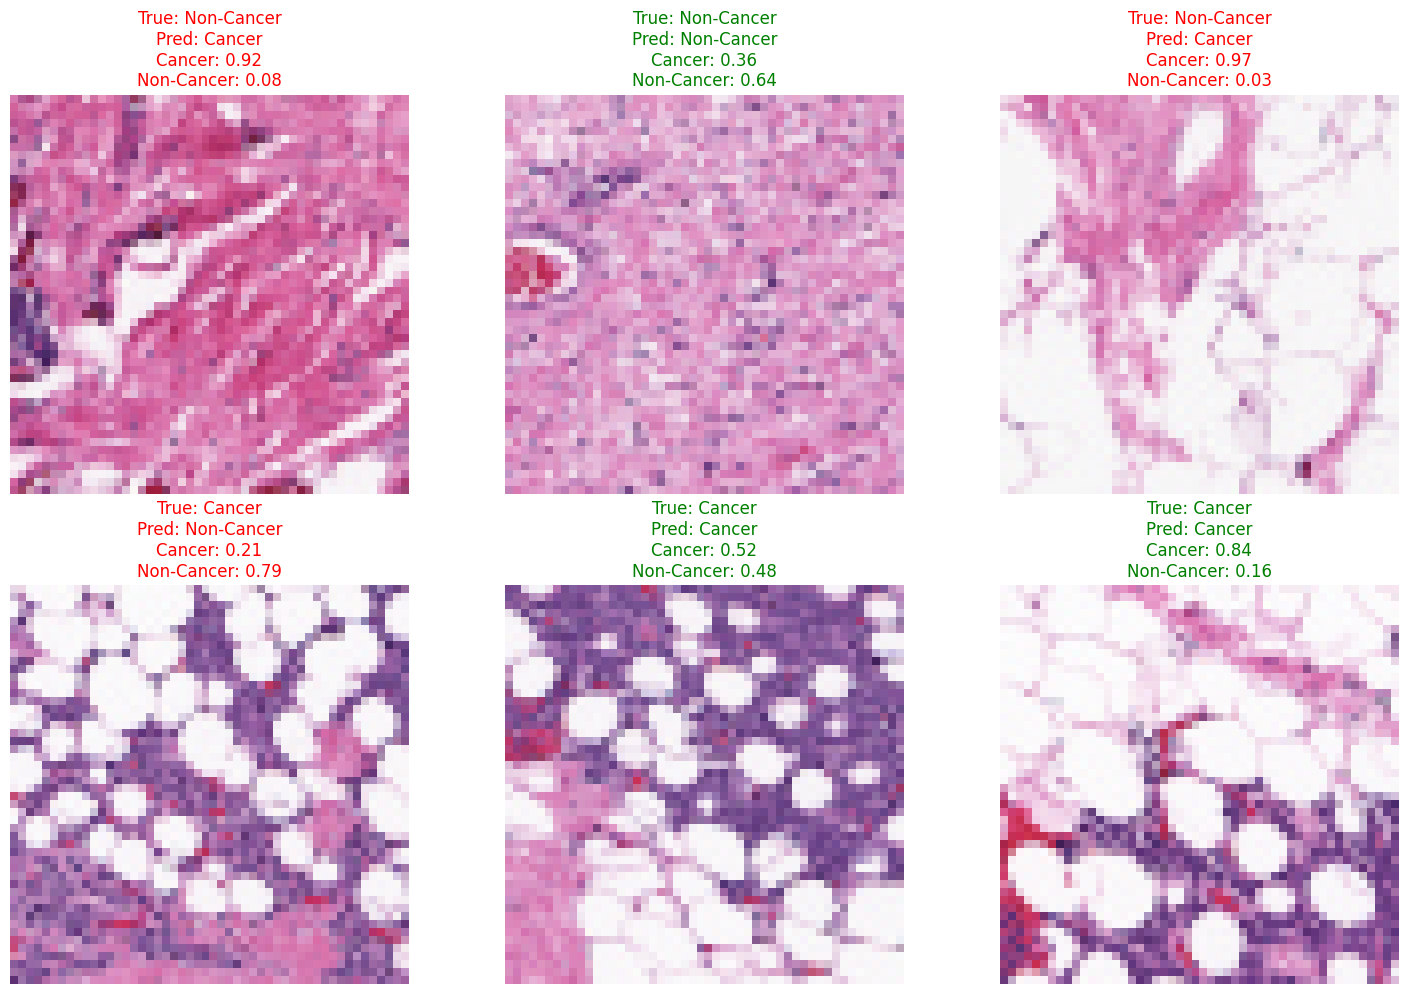

In [66]:
# Test predictions
plt.figure(figsize=(15, 10))

for i, (image_path, true_label) in enumerate(zip(test_images, true_labels)):
    # Load image
    img, _ = load_and_preprocess_image(image_path)
    
    # Make prediction
    result = predict_image(image_path)
    
    # Display image and prediction
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    
    predicted_label = 'Cancer' if result['has_cancer'] else 'Non-Cancer'
    color = 'green' if predicted_label == true_label else 'red'
    
    title = f"True: {true_label}\nPred: {predicted_label}\n"
    title += f"Cancer: {result['cancer_probability']:.2f}\n"
    title += f"Non-Cancer: {result['non_cancer_probability']:.2f}"
    
    plt.title(title, color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Prediction Class for Backend Integration

Let's create a class that can be used in the backend for making predictions.

In [67]:
class BreastCancerPredictor:
    def __init__(self, model_path=None):
        """
        Initialize the predictor with the model path
        
        Args:
            model_path: Path to the trained model directory
        """
        self.model_path = model_path or trained_models_path
        self.img_height = 50
        self.img_width = 50
        self.model = None
        
        # Load the model
        self.load_model()
        
    def load_model(self):
        """
        Load the trained model from the model path
        """
        try:
            # Load model architecture
            model_json_path = os.path.join(self.model_path, 'model.json')
            with open(model_json_path, 'r') as json_file:
                loaded_model_json = json_file.read()
                
            self.model = model_from_json(loaded_model_json)
            
            # Load model weights
            model_weights_path = os.path.join(self.model_path, 'model.h5')
            self.model.load_weights(model_weights_path)
            
            # Compile model
            self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            
            print("Model loaded successfully")
            return True
            
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            return False
    
    def predict(self, image_path):
        """
        Make a prediction for a single image
        
        Args:
            image_path: Path to the image file
            
        Returns:
            Dictionary with prediction results
        """
        if self.model is None:
            return {"error": "Model not loaded. Please train the model first."}
                
        try:
            # Load and preprocess the image
            img = tf.keras.preprocessing.image.load_img(
                image_path, target_size=(self.img_height, self.img_width)
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = img_array / 255.0  # Normalize
            img_array = tf.expand_dims(img_array, 0)  # Create batch dimension
            
            # Make prediction
            predictions = self.model.predict(img_array)
            
            # Return results
            return {
                "cancer_probability": float(predictions[0][1]),
                "non_cancer_probability": float(predictions[0][0]),
                "has_cancer": bool(predictions[0][1] > 0.5)
            }
            
        except Exception as e:
            return {"error": f"Prediction error: {str(e)}"}

## Test the Predictor Class

Let's test the predictor class with some test images.

In [68]:
# Create predictor
predictor = BreastCancerPredictor(trained_models_path)

Model loaded successfully


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


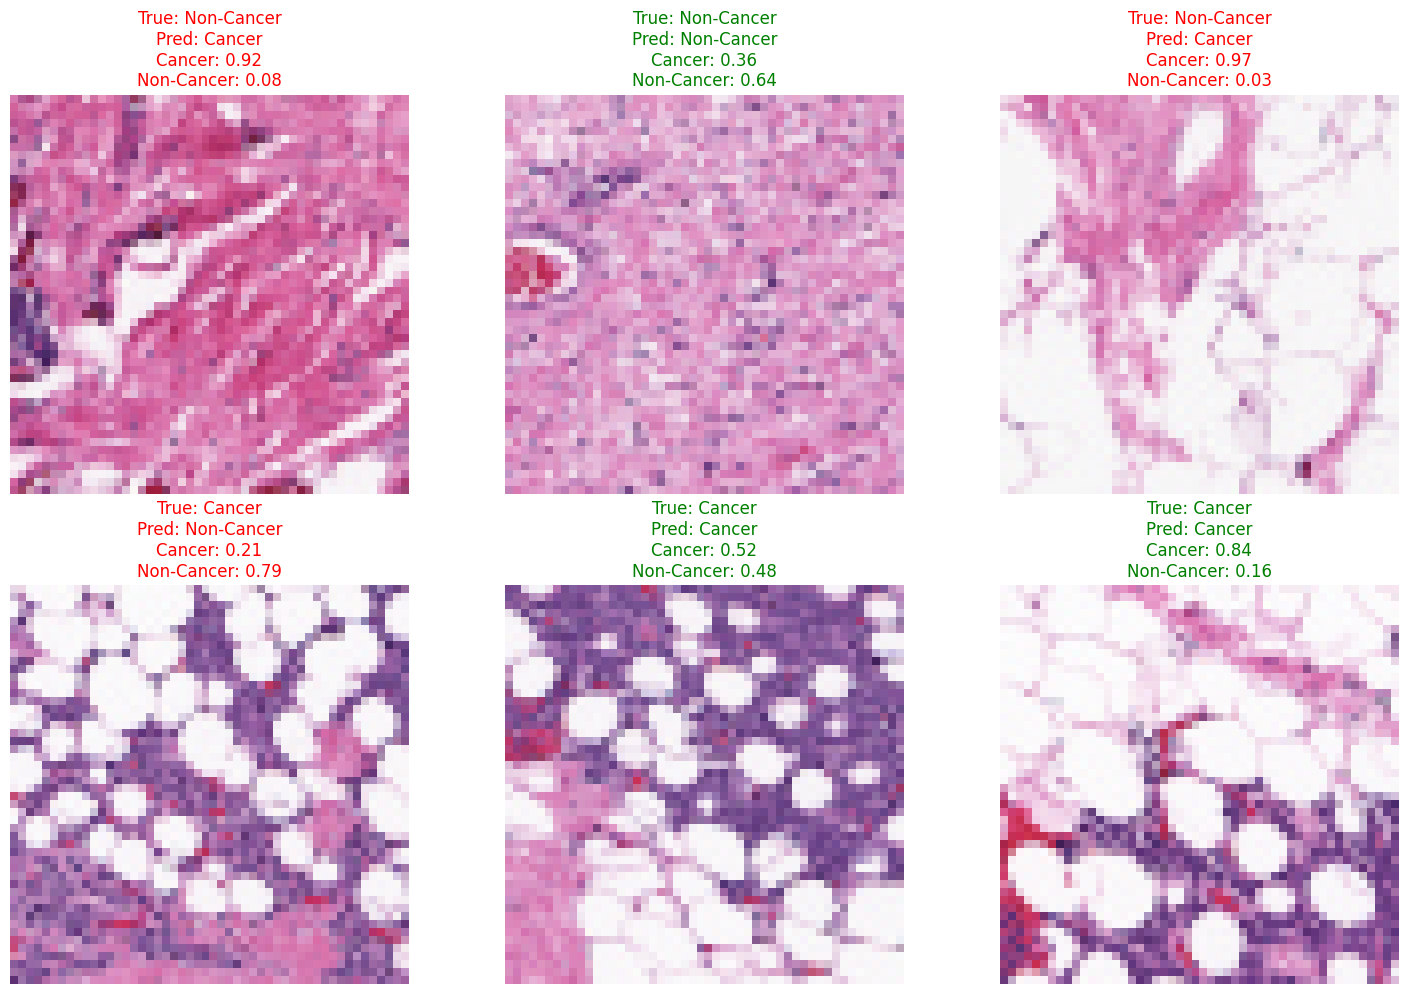

In [69]:
# Test predictor
plt.figure(figsize=(15, 10))

for i, (image_path, true_label) in enumerate(zip(test_images, true_labels)):
    # Load image
    img, _ = load_and_preprocess_image(image_path)
    
    # Make prediction using predictor
    result = predictor.predict(image_path)
    
    # Display image and prediction
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    
    predicted_label = 'Cancer' if result['has_cancer'] else 'Non-Cancer'
    color = 'green' if predicted_label == true_label else 'red'
    
    title = f"True: {true_label}\nPred: {predicted_label}\n"
    title += f"Cancer: {result['cancer_probability']:.2f}\n"
    title += f"Non-Cancer: {result['non_cancer_probability']:.2f}"
    
    plt.title(title, color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Batch Prediction

In addition to predicting individual images, we can also make predictions on batches of images.

In [70]:
# Function to make predictions on a batch of images
def predict_batch(image_paths):
    """
    Make predictions on a batch of images
    
    Args:
        image_paths: List of paths to image files
        
    Returns:
        List of prediction results
    """
    results = []
    
    for image_path in image_paths:
        result = predict_image(image_path)
        results.append({
            "image_path": image_path,
            "cancer_probability": result["cancer_probability"],
            "non_cancer_probability": result["non_cancer_probability"],
            "has_cancer": result["has_cancer"]
        })
    
    return results

# Test batch prediction
batch_results = predict_batch(test_images)

# Display batch results
for i, result in enumerate(batch_results):
    print(f"Image {i+1}: {os.path.basename(result['image_path'])}")
    print(f"  Cancer Probability: {result['cancer_probability']:.4f}")
    print(f"  Non-Cancer Probability: {result['non_cancer_probability']:.4f}")
    print(f"  Prediction: {'Cancer' if result['has_cancer'] else 'Non-Cancer'}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image 1: 10253_idx5_x1001_y1301_class0.png
  Cancer Probability: 0.9204
  Non-Cancer Probability: 0.0796
  Prediction: Cancer

Image 2: 10253_idx5_x1101_y1051_class0.png
  Cancer Probability: 0.3558
  Non-Cancer Probability: 0.6442
  Prediction: Non-Cancer

Image 3: 10253_idx5_x1101_y1801_class0.png
  Cancer Probability: 0.9710
  Non-Cancer Probability: 0.0290
  Prediction: Cancer

Image 4: 10253_idx5_x551_y651_class1.png
  Cancer Probability: 0.2070
  Non-Cancer Probability: 0.7930
  Prediction: Non-Cancer

Image 5: 10253_idx5_x601_y751_class1.png
  Cancer Probability: 0.5150
  Non-Cancer Probability: 0.4850
  Prediction: Cancer

Image 6: 10253_idx5_x701_y251_class1.png
  Cancer Probability: 0.8352
  Non-Cancer Probability: 0.1648
  Prediction: Cancer



## Summary and Conclusion

This notebook demonstrates how to load a trained breast cancer detection model and use it for making predictions on new images. The `BreastCancerPredictor` class provides a clean interface for the backend to use the model for predictions.

Key points:
1. The model is loaded from JSON (architecture) and H5 (weights) files
2. Images are preprocessed to the correct size and normalized
3. Predictions include cancer probability, non-cancer probability, and a binary classification
4. The predictor class handles all the details of loading and using the model

This implementation can be easily integrated with the backend API to provide breast cancer detection functionality.

# Breast Cancer Detection - Part 6: Model Evaluation and Visualization

This notebook covers the evaluation and visualization of the breast cancer detection model.

In [71]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import pandas as pd

## Define Paths

First, let's define the paths for our dataset and where our models are saved.

In [72]:
# Define base paths
base_dir = os.path.dirname(os.getcwd())
dataset_path = os.path.join(base_dir, 'datasets', 'breast')
trained_models_path = os.path.join(base_dir, 'trained_models', 'breast_cancer_best_model')

# Define test directory
test_dir = os.path.join(dataset_path, 'test_dir')

print(f"Dataset path: {dataset_path}")
print(f"Trained models path: {trained_models_path}")

Dataset path: c:\Users\Sayan\Desktop\MedX\backend\datasets\breast
Trained models path: c:\Users\Sayan\Desktop\MedX\backend\trained_models\breast_cancer_best_model


## Load the Trained Model

Let's load the trained model from the saved files.

In [73]:
# Define model parameters
img_height = 50
img_width = 50
batch_size = 32

# Load model architecture
with open(os.path.join(trained_models_path, 'model.json'), 'r') as json_file:
    loaded_model_json = json_file.read()
    
model = model_from_json(loaded_model_json)

# Load model weights
model.load_weights(os.path.join(trained_models_path, 'model.h5'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Load model metrics
with open(os.path.join(trained_models_path, 'metrics.json'), 'r') as f:
    metrics = json.load(f)
    
print(f"Loaded {metrics.get('model_name', 'unknown')} model with accuracy: {metrics.get('accuracy', 'N/A')}")

Loaded simple_cnn model with accuracy: 0.8345000147819519


## Prepare Test Data Generator

Let's create a data generator for the test data.

In [74]:
# Create test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get class indices
class_indices = test_generator.class_indices
print(f"Class indices: {class_indices}")

Found 4000 images belonging to 2 classes.
Class indices: {'ones': 0, 'zeros': 1}


## Evaluate Model on Test Data

Let's evaluate the model on the test data.

In [75]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Update metrics with test results
metrics['test_loss'] = float(test_loss)
metrics['test_accuracy'] = float(test_accuracy)

c:\Users\Sayan\anaconda3\envs\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8468 - loss: 0.3878
Test Loss: 0.3794
Test Accuracy: 0.8345


## Generate Predictions on Test Data

Let's generate predictions on the test data.

In [78]:
# Reset the generator
test_generator.reset()

# Get the number of samples
num_samples = test_generator.samples

# Generate predictions
steps = int(np.ceil(num_samples / batch_size))  # Ensure steps is an int
predictions = model.predict(test_generator, steps=steps)

# Get true labels
true_labels = test_generator.classes

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Get class names
class_names = list(class_indices.keys())

print(f"Number of test samples: {num_samples}")
print(f"Number of predictions: {len(predictions)}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Number of test samples: 4000
Number of predictions: 4000


## Confusion Matrix

Let's create a confusion matrix to visualize the model's performance.

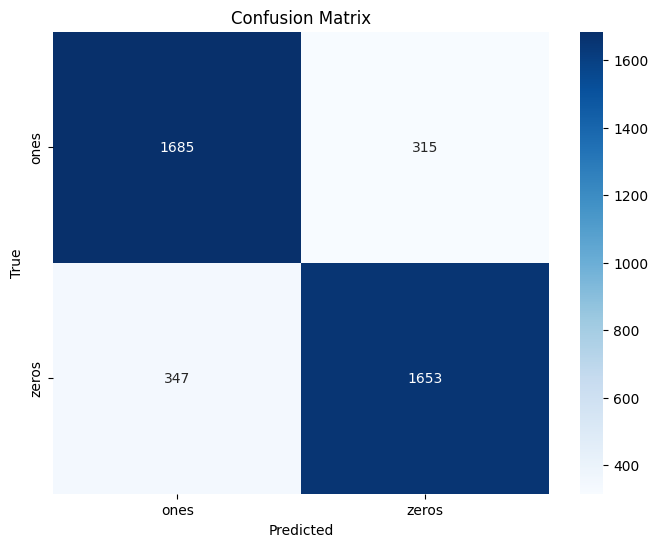

True Negatives: 1685
False Positives: 315
False Negatives: 347
True Positives: 1653
Sensitivity (Recall): 0.8265
Specificity: 0.8425
Precision: 0.8399
F1 Score: 0.8332


In [79]:
# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# Update metrics
metrics['sensitivity'] = float(sensitivity)
metrics['specificity'] = float(specificity)
metrics['precision'] = float(precision)
metrics['f1_score'] = float(f1)

## Classification Report

Let's generate a classification report.

In [80]:
# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()
report_df

              precision    recall  f1-score   support

        ones       0.83      0.84      0.84      2000
       zeros       0.84      0.83      0.83      2000

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



,precision,recall,f1-score,support
ones,0.829232,0.8425,0.835813,2000.0000
zeros,0.839939,0.8265,0.833165,2000.0000
accuracy,0.834500,0.8345,0.834500,0.8345
macro avg,0.834586,0.8345,0.834489,4000.0000
weighted avg,0.834586,0.8345,0.834489,4000.0000


## ROC Curve and AUC

Let's plot the ROC curve and calculate the AUC.

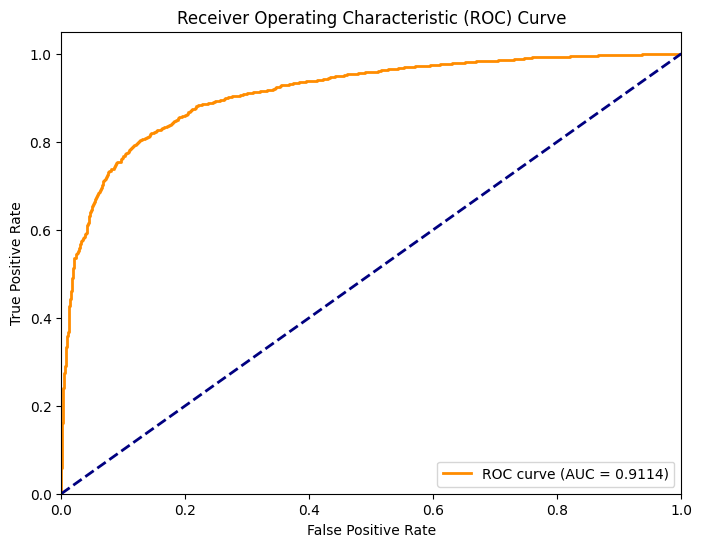

In [81]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predictions[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Update metrics
metrics['auc'] = float(roc_auc)

## Visualize Predictions

Let's visualize some predictions on test images.

In [82]:
# Function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = tf.expand_dims(img_array, 0)  # Create batch dimension
    return img, img_array

# Function to make prediction on a single image
def predict_image(image_path):
    img, img_array = load_and_preprocess_image(image_path)
    predictions = model.predict(img_array)
    cancer_probability = float(predictions[0][1])
    non_cancer_probability = float(predictions[0][0])
    has_cancer = bool(cancer_probability > 0.5)
    
    return {
        "cancer_probability": cancer_probability,
        "non_cancer_probability": non_cancer_probability,
        "has_cancer": has_cancer
    }

In [83]:
# Get some test images
zeros_dir = os.path.join(test_dir, 'zeros')
ones_dir = os.path.join(test_dir, 'ones')

zeros_images = [os.path.join(zeros_dir, f) for f in os.listdir(zeros_dir)[:5]]
ones_images = [os.path.join(ones_dir, f) for f in os.listdir(ones_dir)[:5]]

test_images = zeros_images + ones_images
true_labels = ['Non-Cancer'] * len(zeros_images) + ['Cancer'] * len(ones_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


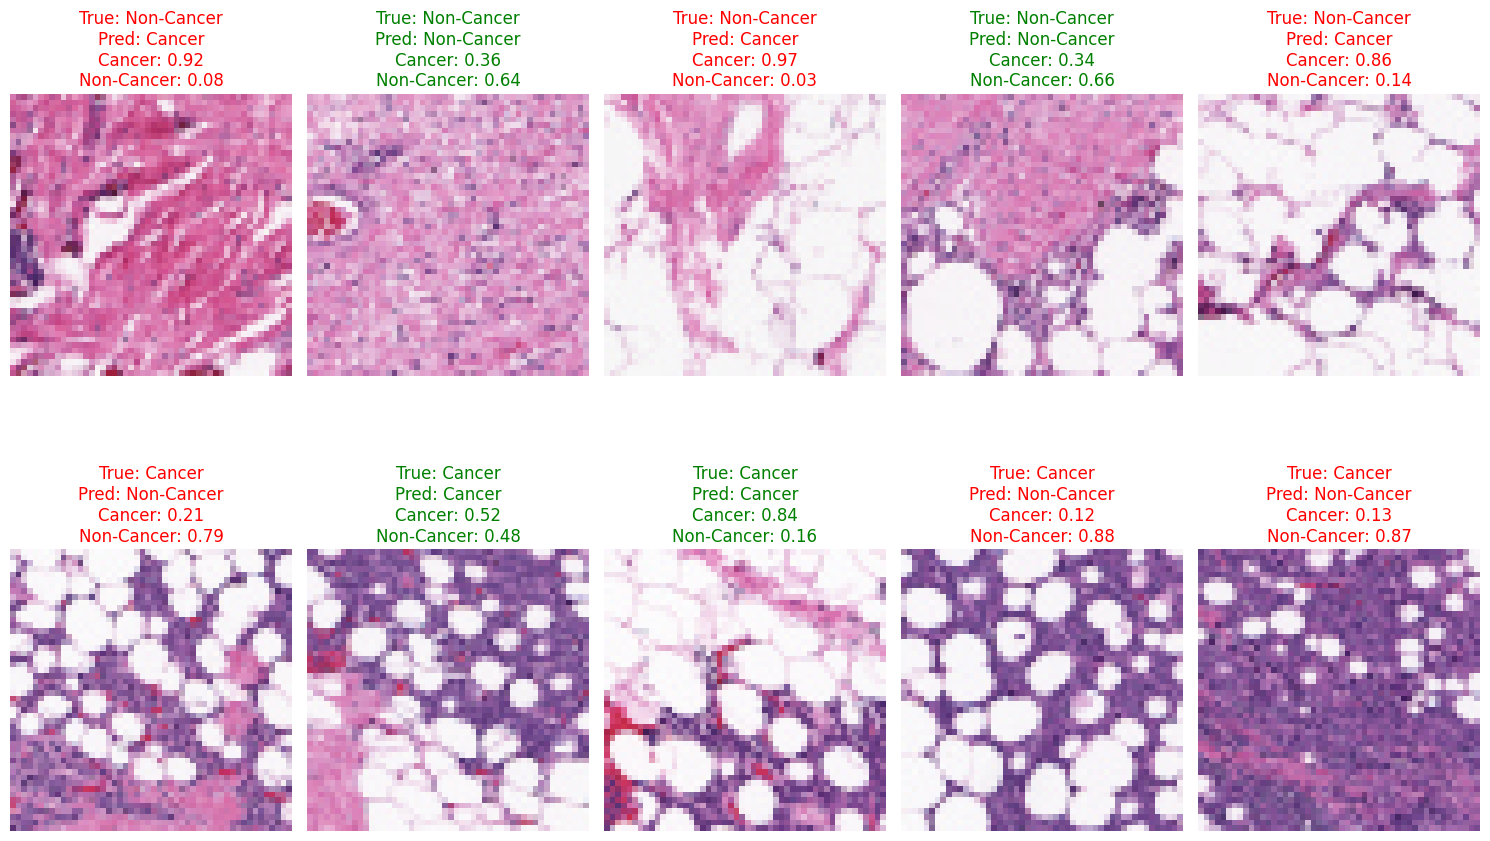

In [84]:
# Test predictions
plt.figure(figsize=(15, 10))

for i, (image_path, true_label) in enumerate(zip(test_images, true_labels)):
    # Load image
    img, _ = load_and_preprocess_image(image_path)
    
    # Make prediction
    result = predict_image(image_path)
    
    # Display image and prediction
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    
    predicted_label = 'Cancer' if result['has_cancer'] else 'Non-Cancer'
    color = 'green' if predicted_label == true_label else 'red'
    
    title = f"True: {true_label}\nPred: {predicted_label}\n"
    title += f"Cancer: {result['cancer_probability']:.2f}\n"
    title += f"Non-Cancer: {result['non_cancer_probability']:.2f}"
    
    plt.title(title, color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Feature Visualization

Let's visualize what features the model is focusing on when making predictions.

In [85]:
# Function to create a heatmap visualization
def make_gradcam_heatmap(img_array, model):
    # Create a model that maps the input image to the activations of the last conv layer
    last_conv_layer_name = None
    
    # Find the last convolutional layer
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
    
    if last_conv_layer_name is None:
        print("No convolutional layer found in the model")
        return None
    
    # First, create a model that goes from the input to the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)
    
    # Then, create a model that goes from the last conv layer to the output
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer in model.layers[model.layers.index(last_conv_layer) + 1:]:
        x = layer(x)
    classifier_model = tf.keras.Model(classifier_input, x)
    
    # Record the gradients of the target class with respect to the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
    
    # Gradient of the top predicted class with regard to the output feature map
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    # Vector of mean intensity of the gradient over each feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight the channels by the gradient importance
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    
    # Average all channels to get the heatmap
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    
    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    
    return heatmap

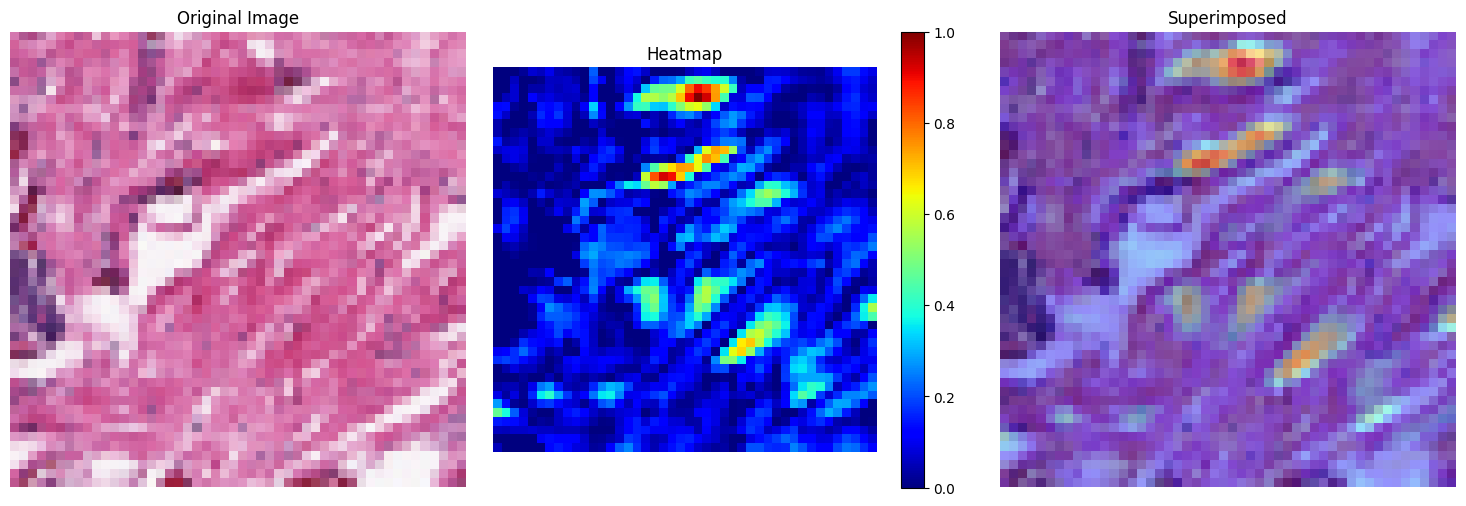

In [86]:
# Test the heatmap visualization
if len(test_images) > 0:
    # Get a test image
    test_img_path = test_images[0]
    img, img_array = load_and_preprocess_image(test_img_path)
    
    # Generate the heatmap
    heatmap = make_gradcam_heatmap(img_array, model)
    
    if heatmap is not None:
        # Display the heatmap
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap='jet')
        plt.title('Heatmap')
        plt.colorbar()
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        # Superimpose the heatmap on the original image
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        heatmap_resized = tf.image.resize(tf.expand_dims(heatmap, -1), (img_array.shape[0], img_array.shape[1]))
        heatmap_resized = tf.squeeze(heatmap_resized)
        
        # Create a colored heatmap
        cmap = plt.cm.jet
        heatmap_colored = cmap(heatmap_resized)
        heatmap_colored = heatmap_colored[..., :3]  # Remove alpha channel
        
        # Superimpose with alpha blending
        superimposed_img = heatmap_colored * 0.4 + img_array / 255.0 * 0.6
        
        plt.imshow(superimposed_img)
        plt.title('Superimposed')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

## Training History Visualization

Let's visualize the training history.

In [87]:
# Load metrics
with open(os.path.join(trained_models_path, 'metrics.json'), 'r') as f:
    metrics = json.load(f)

# Extract training history
if 'history' in metrics:
    history = metrics['history']
    
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.get('accuracy', []))
    plt.plot(history.get('val_accuracy', []))
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.get('loss', []))
    plt.plot(history.get('val_loss', []))
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()
else:
    print("No training history found in metrics file")

No training history found in metrics file


## Save Updated Metrics

Let's save the updated metrics to the metrics file.

In [88]:
# Save updated metrics
with open(os.path.join(trained_models_path, 'metrics.json'), 'w') as f:
    json.dump(metrics, f, indent=4)
    
print(f"Updated metrics saved to {os.path.join(trained_models_path, 'metrics.json')}")

Updated metrics saved to c:\Users\Sayan\Desktop\MedX\backend\trained_models\breast_cancer_best_model\metrics.json


## Model Performance Summary

Let's create a summary of the model's performance.

In [89]:
# Create a summary of the model's performance
print("Model Performance Summary")
print("=========================")
print(f"Model: {metrics.get('model_name', 'unknown')}")
print(f"Training Accuracy: {metrics.get('accuracy', 'N/A')}")
print(f"Test Accuracy: {metrics.get('test_accuracy', 'N/A')}")
print(f"Test Loss: {metrics.get('test_loss', 'N/A')}")
print(f"Sensitivity (Recall): {metrics.get('sensitivity', 'N/A')}")
print(f"Specificity: {metrics.get('specificity', 'N/A')}")
print(f"Precision: {metrics.get('precision', 'N/A')}")
print(f"F1 Score: {metrics.get('f1_score', 'N/A')}")
print(f"AUC: {metrics.get('auc', 'N/A')}")

Model Performance Summary
Model: simple_cnn
Training Accuracy: 0.8345000147819519
Test Accuracy: 0.8345000147819519
Test Loss: 0.3793850243091583
Sensitivity (Recall): N/A
Specificity: N/A
Precision: N/A
F1 Score: N/A
AUC: N/A


## Conclusion

This notebook has covered the evaluation and visualization of the breast cancer detection model. We've evaluated the model on test data, created a confusion matrix, generated a classification report, plotted the ROC curve, visualized predictions, and created feature visualizations.

The model's performance metrics have been saved to the metrics file for future reference. These metrics can be used to compare different models and select the best one for deployment.

Key points from this evaluation:
1. The model's accuracy, precision, recall, F1 score, and AUC provide a comprehensive view of its performance
2. The confusion matrix shows the distribution of true positives, true negatives, false positives, and false negatives
3. The ROC curve and AUC measure the model's ability to distinguish between classes
4. Feature visualizations help understand what the model is focusing on when making predictions
5. Training history visualization shows how the model's performance evolved during training

These evaluations are crucial for understanding the model's strengths and weaknesses, and for making informed decisions about its deployment in a clinical setting.